In [1]:
# purpose: Jupyter notebook to create figure 2 ROC curves
# author: Ashray Gunjur
# date: 2023-03-02

# import packages
import sklearn, imblearn, ast, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools as it

## pre-processing
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.fixes import loguniform

# balancers
from imblearn.over_sampling import RandomOverSampler

## estimators
from sklearn.ensemble import RandomForestClassifier

## cross-val / evaluating
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, auc

# set up study cols
col = {
    "UGB":"#EA8B9A",
    "NEN":"#9D83BC",
    "GYN":"#C6A775"
    }

In [2]:
# settings
feats = '^t__'
target = 'R_vs_PD'

# load data
df=pd.read_excel("Supp_tables.xlsx", sheet_name = "metadata_and_clr_abundances")
train = df.filter(regex='%s|%s|c__histology_cohort' % (feats, target), axis =1).dropna()

# load hyperparams (from concatenating results of hyperparam_tuning.py, or pre-made in Supp_tables.xlsx)
hp_all = pd.read_excel("Supp_tables.xlsx", sheet_name = "hyperparam_tuning_all")
string = hp_all[(hp_all['feats']==feats) & (hp_all['target']==target)]['params'].reset_index(drop=True)
hp = ast.literal_eval(string[0])

# set up classifier based on tuned hyperparameters
clf = RandomForestClassifier(n_jobs=-1,
    n_estimators= hp['estimator__n_estimators'],
    max_features= hp['estimator__max_features'],
    max_depth= hp['estimator__max_depth'],
    min_samples_split= hp['estimator__min_samples_split'],
    min_samples_leaf= hp['estimator__min_samples_leaf'],
    bootstrap= hp['estimator__bootstrap'],
    criterion=hp['estimator__criterion'],
    oob_score = True
                            )

# split into feature, target, group sets
X = train.filter(regex='%s'% (feats), axis = 1)
y = train[target].astype('bool').values
groups = train['c__histology_cohort'].values

In [3]:
# --------------
#  pipeline
# --------------

# define column types
numericals = X.select_dtypes(include=['int64', 'float64']).columns
categoricals = X.select_dtypes(include=['category','object', 'bool']).columns

# create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numericals),
        ("cat", OneHotEncoder(drop = 'first', handle_unknown ='ignore'), categoricals),
    ]
)

# create pipeline
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("balancer", RandomOverSampler()),
    ("estimator", clf)
])


In [4]:
#=========================#
# FIG 2C- LOGO ROC CURVES #
#=========================#

# Use LeaveOneGroupOut cross-validation to split the data
cv = LeaveOneGroupOut()

# Repeat the cross-validation N times
probs_list = []
N = 100

for n in tqdm(range(N)):
    # Use cross_val_predict to predict probabilities for each run of cross-validation
    y_probs = cross_val_predict(pipe, X=X, y=y, groups=groups, cv=cv, method="predict_proba")
    y_probs_true = y_probs[:,1]
    probs_list.append(y_probs_true)
    
# average repeats to account for stochasticity of RF pipeline
repeats = pd.DataFrame(probs_list).transpose()
repeats['mean_y_prob_true'] = repeats.mean(axis=1)
repeats['group'] = groups
repeats['y'] = y


100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


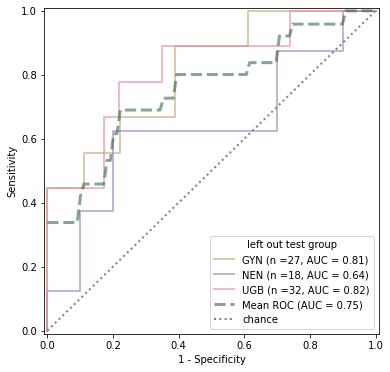

In [5]:
# set up LOGO plot
fig, ax = plt.subplots(figsize=(6,6))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
cv = LeaveOneGroupOut()

# plot sub-groups
for g in np.unique(repeats['group']):
    fold_df = repeats[repeats['group']==g]
    fpr, tpr, thresholds = roc_curve(fold_df['y'], fold_df['mean_y_prob_true'])
    score = roc_auc_score(fold_df['y'], fold_df['mean_y_prob_true'])
    cl = col[g]
    plt.plot(fpr, tpr, lw=2, color = cl, alpha = 0.6, label=f'{g} (n ={fold_df.shape[0]}, AUC = {round(score,2)})')
    # save tprs
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(score)

# plot average
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, lw=3, alpha = 0.6, color = "#356949", linestyle="dashed", label = f'Mean ROC (AUC = {round(mean_auc,2)})')
    
# PLOt the ROC AUC curves    
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='dotted', label = "chance")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(title='left out test group',loc='lower right')
plt.show()

In [6]:
#=========================#
# OPTIONAL- OOB ROC CURVE #
#=========================#

oob_decision_functions = []

# repeat N times:
N=100
for n in tqdm(range(N)):

    #apply the preprocessing (not random oversampling- this would result in data leakage)
    X_pp = pipe['preprocessor'].fit_transform(X,y)

    # fit
    pipe['estimator'].fit(X_pp, y)    

    # get oob decision functions
    y_oob_df = pipe['estimator'].oob_decision_function_[:,1]
    
    oob_decision_functions.append(y_oob_df)
    
# average oob_decision_functions
mean_df = np.mean(oob_decision_functions, axis = 0)

# create dataframe
d = pd.DataFrame({'y_true':y.tolist(), 'y_score':mean_df.tolist(), 'group': groups.tolist()})

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


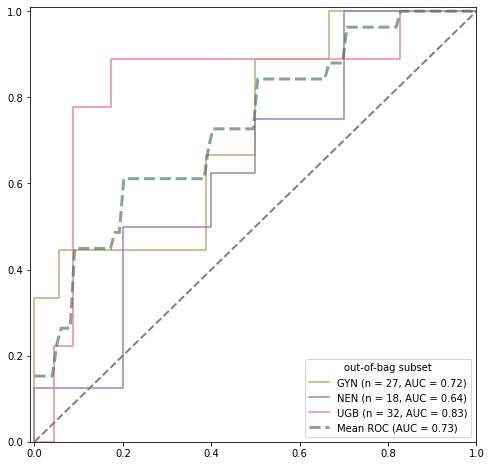

In [7]:
# set up OOB plot
fig, ax = plt.subplots(figsize=(8,8))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for g in np.unique(groups):
    # subset dataframe by group
    subset = d[d['group']==g]
    y_score = subset['y_score'].values
    y_true = subset['y_true'].values
    cl = col[g]

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, label='%s (n = %d, AUC = %0.2f)' % (g, subset.shape[0], auc_score), color = cl)
    
    # save tprs
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(auc_score)

# plot average
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, lw=3, alpha = 0.6, color = "#356949", linestyle="dashed", label = f'Mean ROC (AUC = {round(mean_auc,2)})')
    
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.legend(title='out-of-bag subset',loc='lower right')
plt.show()